#**Выявление ключевых слов в русскоязычных текстах по теме "Образование"**

Материалы новостных статей образовательного портала «EDU-Inform». 
Данный ресурс является информационно-справочным порталом, который содержит сведения об образовательных заведениях России всех уровней (дошкольное образование, школьное, высшее, профессиональное, дополнительное), а также их структуре, направлениях деятельности и перечне предоставляемых услуг. 

http://edu-inform.ru

---



In [ ]:
# устанавиливаем библиотеки и модули 
! pip3 install requests # для парсинга сайтов
! pip3 install beautifulsoup4 # для удобной работы с html-тегами
! pip3 install sentence-transformers # для Keyword Extraction
! pip3 install pymorphy2 # для лемматизации русскоязычного текста


     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 2.8 MB 51.5 MB/s 
     |████████████████████████████████| 1.2 MB 71.4 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 636 kB 92.5 MB/s 
     |████████████████████████████████| 895 kB 92.8 MB/s 
     |████████████████████████████████| 3.3 MB 64.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126710 sha256=ffd07dfb621704769eb675f01af9ebb429d7dc1c27c4a5841c133092eb61d373
  Stored in directory: /root/.cache/pip/wheels/d1/c1/0f/faafd427f705c4b012274ba60d9a91d75830306811e1355293
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 8.2 MB 36.9 MB/s 


In [ ]:
# импортируем необходимые модули для парсинга сайта
import requests
from bs4 import BeautifulSoup

# импортируем необходимые модули для формирования датафрейма
import pandas as pd
from google.colab import files

# импортируем необходимые модули для предпроцессинга и лемматизации текстов
import nltk
import string
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words("russian")
stop_words_ru = stopwords.words('russian')
from nltk.tokenize import sent_tokenize,word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()

# импортируем необходимые модули для визуализации
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np

# импортируем необходимые модули для извлечения ключевых слов (Keyword Extraction) с помощью KeyBERT
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens') # можно также использовать модель xlm-r-distilroberta-base-paraphase-v1 (не сработало)
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/450 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Обновляем лист стоп-слов, чтобы убрать месяца и другие нерелевантные слова

removal_list = ['январь', 'рособрнадзор','государственный', 'представитель', 'санктпетербургский', 'дальневосточный', 'санктпетербург', 'новосибирский', 'лобачевский', 'южноуральский', 'правительство', 'минпросвещение', 'общественный', 'распоряжение', 'предусматривать', 'ежемесячный', 'минобранауки', 'негосударственный', 'ежемесячный', 'постановление', 'соответствующий', 'здравоохранение', 'административный', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь', 'министерство', 'москва', 'московский'] # стоп-слова чтобы убрать даты в тесте статьи
stop_words_ru.extend(removal_list)	
print(stop_words_ru)


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [ ]:
# функция для обработки URL-адресов страниц
def get_soup(url, **kwargs):
    response = requests.get(url, **kwargs)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, features='html.parser')
    else:
        soup = None
    return soup

In [ ]:
# функция для сбора ссылок на страницы со статьями на сайте журнала "Study in Russia" 
# принимает на вход количество страниц со статьями, а на выходе возвращает список ссылок на статьи с этих страниц

def crawl_links_ru(pages_count):
    urls = []
    fmt = 'http://edu-inform.ru/news/?PAGEN_1={page}' # шаблон URL-адреса страницы со статьями
    
    for page_n in range(1, 1 + pages_count):
        print('page: {}'.format(page_n))

        page_url = fmt.format(page=page_n)
        soup = get_soup(page_url)
        if soup is None:
            break

        for tag in soup.find_all('div', {'class': 'i-wid30'}): # находим один тег в котором хранится ссылка на статью, чтобы избежать дублирования
            tagsoup = tag
            for tag in tagsoup.select('a'): # сохраняем ссылку на статью
                href = tag.attrs['href']
                url = 'http://edu-inform.ru{}'.format(href)
                urls.append(url) 

    return urls

In [ ]:
# функция для парсинга текста статей портала "EDU-Inform"
# принимает список URL-адресов, парсит необходимую информацию по каждой статье и добавляет её в общий массив data, который и возвращает

def parse_links_ru(urls):
    data = []

    for url in urls:
        soup = get_soup(url)
        if soup is None:
            break

        title = soup.select_one('title').text.strip() # сохраняем заголовок статьи 
        article_url = url # сохраняем ссылку на статью
        texts = []
        for tag in soup.find_all('p'): # сохраняем текст публикаций
            texts.append(tag.text.strip())
            article_text = ' '.join(texts) # сохраняем текст статьи как строку
        date = soup.find('div', {'class': 'i-news-info-date'}).text.strip() # сохраняем дату публикации

        item = {
            'Title': title,
            'Date': date,
            'Link': url,
            'Text': article_text,
        }
        data.append(item)

# чтобы сохранить результат используем метод pd.DataFrame(), где аргументом подадим словарь из полученных данных
    result = pd.DataFrame(data)
    
    return result    

In [ ]:
# Собираем информацию с сайта портала "EDU-Inform" 

Full_EDUarticles_dataset_ru_18Aug2021 = parse_links_ru(crawl_links_ru(112)) # cобираем информацию по статьям (по данным на 17.08.2021 на сайте всего 112 страниц с новостями)
# в период с июня 2014 по август 2021 - 40 страниц
Full_EDUarticles_dataset_ru_18Aug2021.to_csv('Full_EDUarticles_dataset_ru_18Aug2021.csv', index=False) #сохраняем полученные данные в формат csv
Full_EDUarticles_dataset_ru_18Aug2021 

page: 1
page: 2
page: 3
page: 4
page: 5
page: 6
page: 7
page: 8
page: 9
page: 10
page: 11
page: 12
page: 13
page: 14
page: 15
page: 16
page: 17
page: 18
page: 19
page: 20
page: 21
page: 22
page: 23
page: 24
page: 25
page: 26
page: 27
page: 28
page: 29
page: 30
page: 31
page: 32
page: 33
page: 34
page: 35
page: 36
page: 37
page: 38
page: 39
page: 40
page: 41
page: 42
page: 43
page: 44
page: 45
page: 46
page: 47
page: 48
page: 49
page: 50
page: 51
page: 52
page: 53
page: 54
page: 55
page: 56
page: 57
page: 58
page: 59
page: 60
page: 61
page: 62
page: 63
page: 64
page: 65
page: 66
page: 67
page: 68
page: 69
page: 70
page: 71
page: 72
page: 73
page: 74
page: 75
page: 76
page: 77
page: 78
page: 79
page: 80
page: 81
page: 82
page: 83
page: 84
page: 85
page: 86
page: 87
page: 88
page: 89
page: 90
page: 91
page: 92
page: 93
page: 94
page: 95
page: 96
page: 97
page: 98
page: 99
page: 100
page: 101
page: 102
page: 103
page: 104
page: 105
page: 106
page: 107
page: 108
page: 109
page: 110
page: 11

Title  ...                                               Text
0     Минобрнауки рекомендует перевести непривитых с...  ...  Вузам желательно перевести не привитых от COVI...
1     В Москве завершилось публичное обсуждение прое...  ...  29 июня на площадке Университета «Синергия» пр...
2     В Москве обсудят внедрение курсов по изучению ...  ...  29 июня в Москве на площадке Университета «Син...
3     В российских школах появятся курсы по искусств...  ...  С 1 сентября ученики некоторых школ России нач...
4     С 1 сентября кураторы групп в колледжах будут ...  ...  Минпросвещения России разработало проект поста...
...                                                 ...  ...                                                ...
1114  Московский образовательный эксперимент расшири...  ...  Как стало известно во вторник, московским прав...
1115   Выпускникам российских вузов не хватило дипломов  ...  Выпускники ряда российских вузов не смогли пол...
1116  Студенты смогут учиться в частных вузах за гос...  ...  Госдума в среду приняла в первом чтении поправ...
1117                                Стандарт профанации  ...  Новый образовательный стандарт, на который все...
1118         Через три года мест в детсадах хватит всем  ...  "Этим летом в лагерях и санаториях отдохнут 28...

[1119 rows x 4 columns]

In [ ]:
# откроем получившийся файл csv и сохраним все тексты статей из таблицы в привычный питонский список

ru_df = pd.read_csv('Full_EDUarticles_dataset_ru_18Aug2021.csv', encoding="utf-8") 
list_ru_texts = list(ru_df["Text"].values) 
 
print(type(list_ru_texts)) # проверяем тип переменной
list_ru_texts

<class 'list'>


['Вузам желательно перевести не привитых от COVID-19 студентов на удаленку, говорится в рекомендациях Минобранауки, которые есть в распоряжении ТАСС. Также вузам необходимо организовать вакцинацию иностранных студентов за свой счет. «С учетом эпидемиологической ситуации в каждом конкретном субъекте РФ организациям целесообразно: ... принимать решения об организации образовательной деятельности с применением электронного обучения, дистанционных образовательных технологий — для обучающихся всех форм обучения, не привившихся от коронавирусной инфекции или имеющих противопоказания к вакцинации»,— сообщается в рекомендация ведомства. Также отмечается, что вузам следует организовать вакцинацию иностранных студентов за свой счет. В ведомстве добавили, что высшим учебным заведениям желательно проводить экзамены для привившихся и не привившихся студентов раздельно. Накануне глава министерства Валерий Фальков заявил, что от студентов не требуется обязательной вакцинации против коронавируса. Он д

In [ ]:
# функция для предобработки и лемматизации текста

def preprocess_ru_lemmatize(text):
  lower_text = text.lower() # приводим все слова к нижнему регистру
  no_links_text = re.sub(r'https?:\/\/.*[\r\n]*', '', lower_text)  # убираем все ссылки, начинающиеся с https
  no_links_text2 = re.sub(r'www\.\S+\.\S+[\r\n]*', '', no_links_text)  # убираем все ссылки, начинающиеся с www
  no_links_text3 = re.sub(r'\(?\S+\.\S+\.?\S+?[\r\n]*', '', no_links_text2)  # убираем все ссылки без www
  no_email_text = re.sub(r'\S+@\S+', '', no_links_text3)  # убираем все адреса email
  no_extra_punct = re.sub('[0-9‘’–‑“”£•®«»№A-Za-z©%]', '', no_email_text)  # убираем нетипичные знаки пунктуации, цифры, слова на латинице (при необходимости можно увеличить список вручную)
  text_without_punct = no_extra_punct.translate(str.maketrans('', '', string.punctuation)) # убираем пунктуацию из текста
  text_tokens = word_tokenize(text_without_punct, language="russian") # токенизируем текст превращая его в список 
  
  filtered_tokens = [w for w in text_tokens if w not in stop_words_ru] # доп.строка чтобы убрать стоп слова
  # при необходимости ее использования изменить text_tokens в следующей строке на filtered_tokens

  text_lemmatized = ' '.join([morph_analyzer.parse(w)[0].normal_form  for w in filtered_tokens])  # лемматизируем токенизированный список и возвращаем его как строку 

  return text_lemmatized

In [ ]:
# функция для предобработки списка текстов и сохранения в новый список

def get_ru_list_preprocessed (texts):

  data = []
  
  for text in texts:
    text_preprocessed = preprocess_ru_lemmatize(text)

    data.append(text_preprocessed)

  return data

In [ ]:
ru_df = pd.read_csv('Full_EDUarticles_dataset_ru_18Aug2021.csv', encoding="utf-8") 
list_ru_texts = ru_df["Text"].values
list_ru_texts

array(['Вузам желательно перевести не привитых от COVID-19 студентов на удаленку, говорится в рекомендациях Минобранауки, которые есть в распоряжении ТАСС. Также вузам необходимо организовать вакцинацию иностранных студентов за свой счет. «С учетом эпидемиологической ситуации в каждом конкретном субъекте РФ организациям целесообразно: ... принимать решения об организации образовательной деятельности с применением электронного обучения, дистанционных образовательных технологий — для обучающихся всех форм обучения, не привившихся от коронавирусной инфекции или имеющих противопоказания к вакцинации»,— сообщается в рекомендация ведомства. Также отмечается, что вузам следует организовать вакцинацию иностранных студентов за свой счет. В ведомстве добавили, что высшим учебным заведениям желательно проводить экзамены для привившихся и не привившихся студентов раздельно. Накануне глава министерства Валерий Фальков заявил, что от студентов не требуется обязательной вакцинации против коронавируса

In [ ]:
list_ru_texts_preprocessed = get_ru_list_preprocessed(list_ru_texts)
list_ru_texts_preprocessed 


['вуз желательно перевести привить студент удалёнка говориться рекомендация который распоряжение тасс также вуз необходимо организовать вакцинация иностранный студент свой счёт учёт эпидемиологический ситуация каждый конкретный субъект рф организация целесообразно принимать решение организация образовательный деятельность применение электронный обучение дистанционный образовательный технология — обучаться форма обучение привиться коронавирусный инфекция иметь противопоказание вакцинации— сообщаться рекомендация ведомство также отмечаться вуз следовать организовать вакцинация иностранный студент свой счёт ведомство добавить высокий учебный заведение желательно проводить экзамен привиться привиться студент раздельно накануне глава министерство валерий фальк заявить студент требоваться обязательный вакцинация против коронавирус добавить иностранный студент мочь вакцинироваться свой счёт пройти вуз который внебюджетный средство мочь организовать процедура минувший июнь совет ректор вуз мос

In [ ]:
# Выявление ключевых слов с помощью метода KeyBERT
# функция для векторизации текста и обучения модели для трансформации

def keyword_model (doc):

  n_gram_range = (1, 1) # количество ключевых слов/словосочетаний (можно менять количество)
  #stop_words_ru = "russian"

  count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words_ru).fit([doc]) # извлекаем ключевые слова/фразы-кандидаты
  candidates = count.get_feature_names() # получаем список строк с кандидатами

  # применение предобученной модели для трансформации 

  doc_embedding = model.encode([doc])
  candidate_embeddings = model.encode(candidates)

  # вычисление косинусной близости 
  top_n = 10 # количество наиболее важных ключевых слов
  distances = cosine_similarity(doc_embedding, candidate_embeddings)
  keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
  
  return keywords

In [ ]:
# функция получения ключевых слов списка текстов

def keyword_list(texts):
  
  data = []
  
  for text in texts:
    keywords = keyword_model(text)

    data.append(keywords)

  return data

In [ ]:
keyword_list_ru = keyword_list(list_ru_texts_preprocessed)
keyword_list_ru

[['коронавирусный',
  'профессиональный',
  'целесообразно',
  'образовательный',
  'вакцинироваться',
  'онлайнтрансляция',
  'противопоказание',
  'эпидемиологический',
  'учебнометодический',
  'общественнопрофессиональный'],
 ['обязательный',
  'своевременный',
  'познакомиться',
  'исполнительный',
  'программирование',
  'сберобразование',
  'профессиональный',
  'образовательный',
  'учебнометодический',
  'общественнопрофессиональный'],
 ['востребовать',
  'искусственный',
  'ленинградский',
  'дополнительный',
  'сберобразование',
  'образовательный',
  'профессиональный',
  'общеобразовательный',
  'учебнометодический',
  'общественнопрофессиональный'],
 ['стратегический',
  'использование',
  'профессиональный',
  'сберобразование',
  'квалифицировать',
  'образовательный',
  'онлайнтрансляция',
  'учебнометодический',
  'общеобразовательный',
  'общественнопрофессиональный'],
 ['онлайнтрансляция',
  'самоуправление',
  'психотропный',
  'профобразование',
  'квалифицировать

In [ ]:
# Обновление датафрейма
# добавляем полученные результаты в датафрейм и сохраняем его под новым именем

upgraded_ru_dataframe = ru_df.assign(Text_preprocessed=list_ru_texts_preprocessed,
                                     Keywords=keyword_list_ru)
upgraded_ru_dataframe.to_csv('Full_EDUru_articles_keywords_dataset_18Aug2021.csv', index=False) #сохраняем полученные данные в формат csv

display(upgraded_ru_dataframe)

Title  ...                                           Keywords
0     Минобрнауки рекомендует перевести непривитых с...  ...  [коронавирусный, профессиональный, целесообраз...
1     В Москве завершилось публичное обсуждение прое...  ...  [обязательный, своевременный, познакомиться, и...
2     В Москве обсудят внедрение курсов по изучению ...  ...  [востребовать, искусственный, ленинградский, д...
3     В российских школах появятся курсы по искусств...  ...  [стратегический, использование, профессиональн...
4     С 1 сентября кураторы групп в колледжах будут ...  ...  [онлайнтрансляция, самоуправление, психотропны...
...                                                 ...  ...                                                ...
1114  Московский образовательный эксперимент расшири...  ...  [финансирование, школучастник, дополнительный,...
1115   Выпускникам российских вузов не хватило дипломов  ...  [прессслужба, распространить, антимонопольщик,...
1116  Студенты смогут учиться в частных вузах за гос...  ...  [распространиться, существенный, предоставлять...
1117                                Стандарт профанации  ...  [клавиатурный, переоборудование, компьютерный,...
1118         Через три года мест в детсадах хватит всем  ...  [долгосрочный, роспотребнадзор, зарегистрирова...

[1119 rows x 6 columns]

In [ ]:
# Визуализация полученных данных
# загружаем финальный датафрейм для визуализации

from google.colab import files
uploaded = files.upload()

Saving Full_EDUru_articles_keywords_dataset_18Aug2021.csv to Full_EDUru_articles_keywords_dataset_18Aug2021.csv


In [ ]:
# если загружаем данные из датафрейма, то получаем список списков, преобразуем его в простой список

ru_df_kw = pd.read_csv('Full_EDUru_articles_keywords_dataset_18Aug2021.csv', encoding="utf-8") 
kw = ru_df_kw["Keywords"].values

keyword_list_ru = re.sub('[\[\]\,\']',' ', (''.join(kw))).split() # превращаем список списков в строку, удаляем знаки пунктуации и превращаем обратно в список
keyword_list_ru

['коронавирусный',
 'профессиональный',
 'целесообразно',
 'образовательный',
 'вакцинироваться',
 'онлайнтрансляция',
 'противопоказание',
 'эпидемиологический',
 'учебнометодический',
 'общественнопрофессиональный',
 'обязательный',
 'своевременный',
 'познакомиться',
 'исполнительный',
 'программирование',
 'сберобразование',
 'профессиональный',
 'образовательный',
 'учебнометодический',
 'общественнопрофессиональный',
 'востребовать',
 'искусственный',
 'ленинградский',
 'дополнительный',
 'сберобразование',
 'образовательный',
 'профессиональный',
 'общеобразовательный',
 'учебнометодический',
 'общественнопрофессиональный',
 'стратегический',
 'использование',
 'профессиональный',
 'сберобразование',
 'квалифицировать',
 'образовательный',
 'онлайнтрансляция',
 'учебнометодический',
 'общеобразовательный',
 'общественнопрофессиональный',
 'онлайнтрансляция',
 'самоуправление',
 'психотропный',
 'профобразование',
 'квалифицировать',
 'профессиональный',
 'учебнометодический',
 '

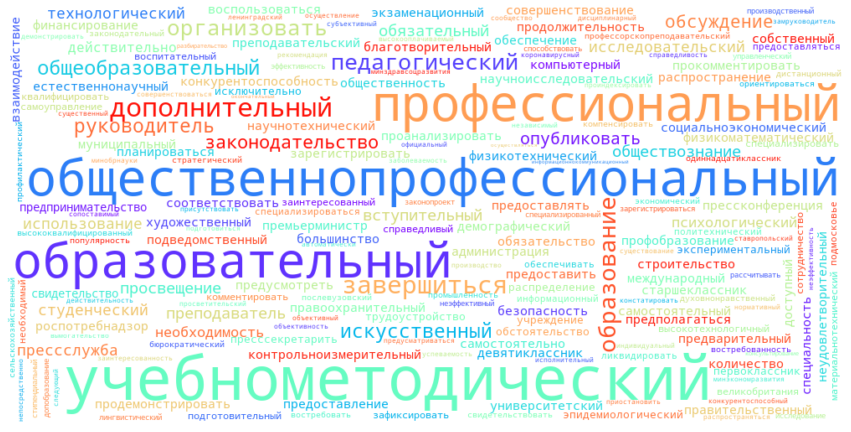

In [ ]:
# Создаем стандартный WordCloud для визуализации данных

word_could_dict_ru=Counter(keyword_list_ru) # преобразует список слов в словарь с количеством их употребления

wordcloud = WordCloud(width = 1000, height = 500, background_color="white", colormap='rainbow').generate_from_frequencies(word_could_dict_ru)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("Full_EDU_education_keywords_ru.png") # сохраняем в файл

In [ ]:
# загружаем файл картинки для того, чтобы сделать облако в форме изображения (формат .png) 
# если цвет фона не белый (225), то применить функцию замены цвета из раздела Extra
from google.colab import files
uploaded = files.upload()

Saving studhat.png to studhat.png


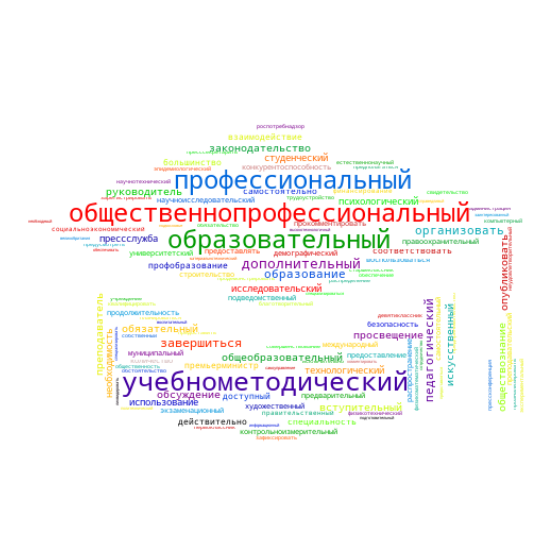

In [ ]:
# Создаем WordCloud в форме картинки
cloud_mask = np.array(Image.open("studhat.png")) # открываем загруженную картинку

wordcloud_masked = WordCloud(background_color="white", mask=cloud_mask, colormap='nipy_spectral').generate_from_frequencies(word_could_dict_ru)

plt.figure(figsize=[20,10])
plt.imshow(wordcloud_masked, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud_masked.to_file("Full_education_keywords_masked_ru.png") # сохраняем в файл

In [ ]:
#Cделать статистику по корпусу
# Sample corpus.

corpus = ''.join(list_ru_texts)


In [ ]:
# определяем статистику по корпусу статей

sents = nltk.sent_tokenize(corpus)
print("The number of sentences:", len(sents))
words = nltk.word_tokenize(corpus)
print("The number of tokens:", len(words))
average_tokens = round(len(words)/len(sents))
print("The average number of tokens per sentence:",average_tokens)
unique_tokens = set(words)
print("The number of unique tokens:", len(unique_tokens))

final_tokens = []
for each in words:
 if each not in stop_words_ru:
    final_tokens.append(each)
print("The number of total tokens after removing stopwords:", len((final_tokens)))

number_of_keywords = len(keyword_list_ru)
print("The number of elements in the keywords list: ", number_of_keywords)
unique_keywords = Counter(word_could_dict_ru).most_common()
number_of_unique_kw = len(unique_keywords) 
print("The number of unique keywords:", (number_of_unique_kw))


The number of sentences: 34960
The number of tokens: 779793
The average number of tokens per sentence: 22
The number of unique tokens: 49199
The number of total tokens after removing stopwords: 643587
The number of elements in the keywords list:  11190
The number of unique keywords: 2281


In [ ]:
Counter(word_could_dict_ru).most_common(50)

[('учебнометодический', 1104),
 ('общественнопрофессиональный', 1104),
 ('профессиональный', 1061),
 ('образовательный', 1040),
 ('дополнительный', 123),
 ('завершиться', 110),
 ('образование', 92),
 ('педагогический', 88),
 ('организовать', 81),
 ('общеобразовательный', 71),
 ('искусственный', 65),
 ('руководитель', 65),
 ('законодательство', 59),
 ('обсуждение', 55),
 ('опубликовать', 50),
 ('просвещение', 47),
 ('обязательный', 46),
 ('преподаватель', 44),
 ('вступительный', 43),
 ('обществознание', 43),
 ('использование', 37),
 ('прессслужба', 36),
 ('исследовательский', 36),
 ('студенческий', 36),
 ('технологический', 35),
 ('психологический', 32),
 ('необходимость', 32),
 ('действительно', 28),
 ('профобразование', 26),
 ('самостоятельно', 26),
 ('специальность', 26),
 ('взаимодействие', 25),
 ('соответствовать', 25),
 ('премьерминистр', 25),
 ('большинство', 25),
 ('доступный', 24),
 ('научноисследовательский', 23),
 ('предварительный', 23),
 ('демографический', 23),
 ('строител

In [ ]:
# Сохраняем данные об уникальных ключевых словах в файл

ru_kwl = list(unique_keywords) # переменная является tuple, сохраняем ее в list
unique_keywords_counter_ru = ' '.join(map(str,ru_kwl)) # преобразуем в строку
with open('Full_EDUunique_keywords_counter_ru.txt', 'w') as f:
  f.write(unique_keywords_counter_ru)

# **Extra**

In [ ]:
#141-150
# функция для сбора ссылок на страницы сайта журнала "Вестник образования"
# принимает на вход количество страниц со статьями, а на выходе возвращает список ссылок на эти страниц

def add_crawl_page_links_ru(pages_count):
    urls = []
    fmt = 'https://vestnik.edu.ru/news?page={page}/' # шаблон URL-адреса страницы со статьями

    for page_n in range(141, pages_count):
        print('page: {}'.format(page_n))

        page_url = fmt.format(page=page_n)
        urls.append(page_url)
        
    return urls 

In [ ]:
url = 'http://edu-inform.ru/news/sergey-kravtsov-prinyal-uchastie-v-torzhestvennoy-tseremonii-nagrazhdeniya-avtorov-luchshikh-sochine/'  
page = requests.get(url) #res/r/response
page # проверим ответ от сайта

soup = BeautifulSoup(page.text, 'html.parser') #сохраним результат в переменную soup
print(soup.prettify()) # показывает нашу страницу в красивом виде

In [ ]:
#пробуем доставать тэги
for tag in soup.find_all('div', class_="i-block-b4"):
    print(tag.text)

In [ ]:
# если работаем с полученной переменной из прошлого шага
# функция для объединения всех ключевых слов в один список

def listmerge(lstlst):
    data=[]
    for lst in lstlst:
        for el in lst:
            data.append(el)
    return data

# применяем функцию к списку списков keywords

my_list_ru = listmerge(keyword_list_ru)
my_list_ru

In [ ]:
# Extra если цвет фона не белый (225), то применить функцию замены ниже

cloud_mask = np.array(Image.open("b_book.png"))
cloud_mask # проверим цвет фона

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

transformed_cloud_mask = np.ndarray((cloud_mask.shape[0],cloud_mask.shape[1]), np.int32)

for i in range(len(cloud_mask)):
    transformed_cloud_mask[i] = list(map(transform_format, cloud_mask[i]))

transformed_cloud_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=int32)